In [2]:
# 导包
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import sys
sys.path.append('/home/dengruijun/data/FinTech/PP-Split/')
# 攻击
from ppsplit.HFL.DLG import DLGAttack
# 模型
from target_model.models.LeNet import LeNet, weights_init
# utils
from ppsplit.utils.utils import create_dir

print(torch.__version__, torchvision.__version__)


1.12.1 0.13.1


In [3]:
# 参数
# parser = argparse.ArgumentParser(description='Deep Leakage from Gradients.')
# parser.add_argument('--index', type=int, default="25",
#                     help='the index for leaking images on CIFAR.')
# parser.add_argument('--image', type=str,default="",
#                     help='the path to customized image.')
# args = parser.parse_args()

args = {'index':25,   # 试图恢复的图片的索引
        'dataset': 'CIFAR100',
}

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Running on %s" % device)
torch.manual_seed(1234) # 随机种子


Running on cuda:0


Files already downloaded and verified
84


LeNet(
  (body): Sequential(
    (0): Conv2d(3, 12, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): Sigmoid()
    (2): Conv2d(12, 12, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (3): Sigmoid()
    (4): Conv2d(12, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): Sigmoid()
  )
  (fc): Sequential(
    (0): Linear(in_features=768, out_features=100, bias=True)
  )
)

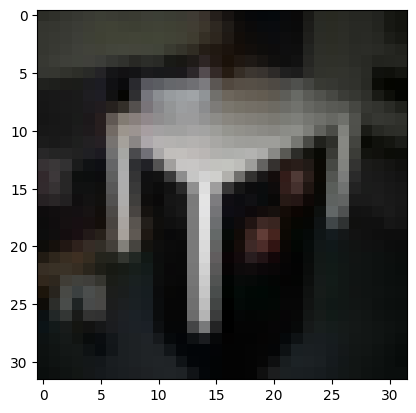

In [4]:
# 数据集模型加载
# cifar100 + LeNet

tt = transforms.ToTensor()
tp = transforms.ToPILImage()
# trainset = datasets.CIFAR100("/home/dengruijun/data/FinTech/DATASET/image-dataset/cifar100/", 
#                              train=True, download=True, transform=transforms.ToTensor())
trainset = datasets.CIFAR100("/home/dengruijun/data/FinTech/DATASET/image-dataset/cifar100/", 
                              download=True, transform=transforms.ToTensor())
# 取一张图片并展示原图
img_index = args['index'] 
data = trainset[img_index]
print(data[1])
plt.imshow(tp(data[0].cpu())) # 展示原始图片

# 模型加载
net = LeNet().to(device)
net.apply(weights_init)


In [11]:
#  攻击
dlg = DLGAttack() # 实例化攻击
[dummy_feature,dummy_label],history = dlg.reconstruct(net,data,NEpoch=300)


Iters:  0  Current Loss: 152.4761
Iters:  10  Current Loss: 5.2151
Iters:  20  Current Loss: 0.8101
Iters:  30  Current Loss: 0.1761
Iters:  40  Current Loss: 0.0640
Iters:  50  Current Loss: 0.0320
Iters:  60  Current Loss: 0.0189
Iters:  70  Current Loss: 0.0126
Iters:  80  Current Loss: 0.0093
Iters:  90  Current Loss: 0.0079
Iters:  100  Current Loss: 0.0067
Iters:  110  Current Loss: 0.0057
Iters:  120  Current Loss: 0.0048
Iters:  130  Current Loss: 0.0040
Iters:  140  Current Loss: 0.0035
Iters:  150  Current Loss: 1064.3284
Iters:  160  Current Loss: 1064.3284
Iters:  170  Current Loss: 1064.3284
Iters:  180  Current Loss: 1064.3284
Iters:  190  Current Loss: 1064.3284
Iters:  200  Current Loss: 1064.3284
Iters:  210  Current Loss: 1064.3284
Iters:  220  Current Loss: 1064.3284
Iters:  230  Current Loss: 1064.3284
Iters:  240  Current Loss: 1064.3284
Iters:  250  Current Loss: 1064.3284
Iters:  260  Current Loss: 1064.3284
Iters:  270  Current Loss: 1064.3284
Iters:  280  Curre

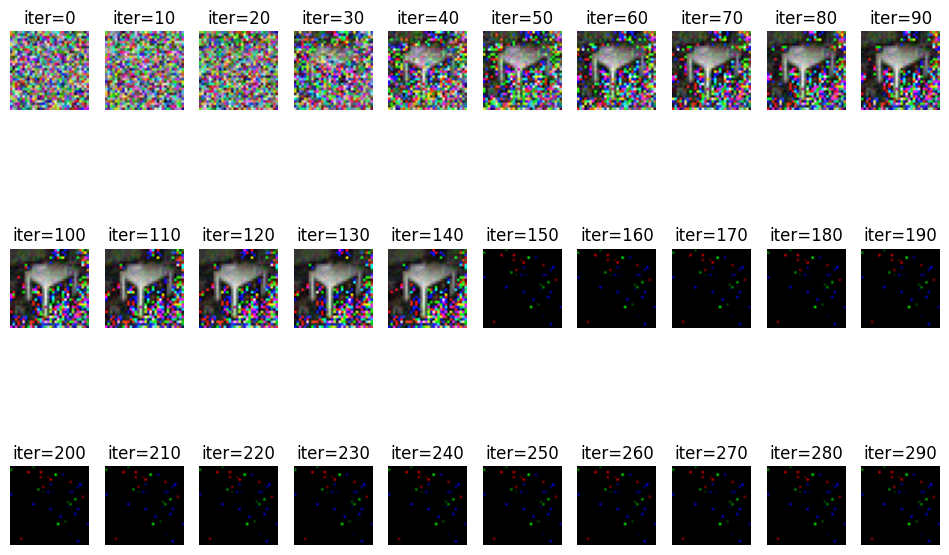

In [13]:
# 画出攻击过程迭代图
dlg.show_optimization_process(history)

1.12.1 0.13.1
Running on cuda:1
Files already downloaded and verified
0 531.7684
10 103.0937
20 85.8000
30 73.3573
40 62.9061
50 55.0911
60 49.1008
70 42.0287
80 37.2563
90 32.7821
100 29.9706
110 28.1939
120 26.7928
130 25.9763
140 25.2118
150 24.2304
160 23.1873
170 22.3680
180 21.7826
190 21.2386
200 20.8508
210 20.4569
220 20.0603
230 19.7001
240 19.3544
250 19.0283
260 18.8058
270 18.5859
280 18.4321
290 18.1886


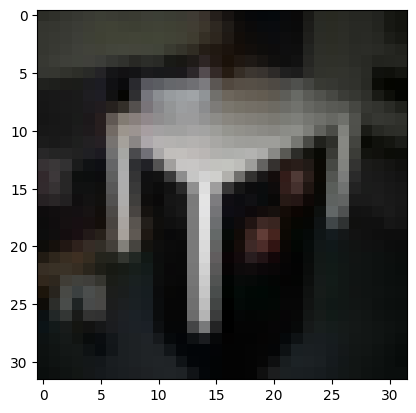

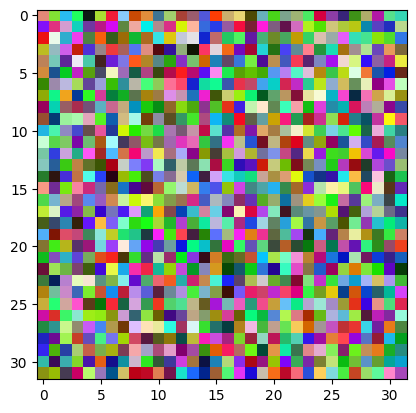

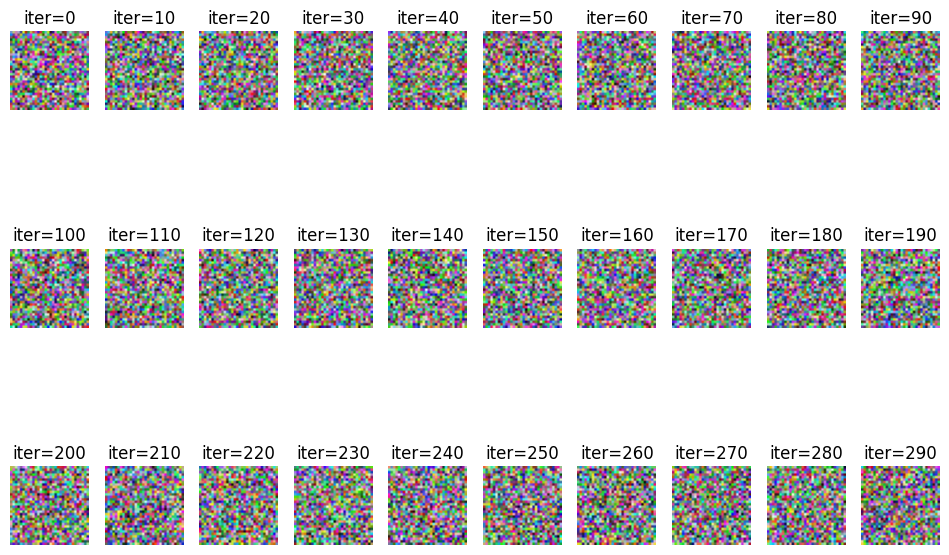

In [8]:
# -*- coding: utf-8 -*-
import argparse
import numpy as np
from pprint import pprint

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import torchvision
from torchvision import models, datasets, transforms
print(torch.__version__, torchvision.__version__)


def label_to_onehot(target, num_classes=100):
    target = torch.unsqueeze(target, 1)
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    onehot_target.scatter_(1, target, 1)
    return onehot_target

def cross_entropy_for_onehot(pred, target):
    return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))

# GPU使用
device = "cpu"
if torch.cuda.is_available():
    device = "cuda:1"
print("Running on %s" % device)

# 数据集 加载并进行transform
# 默认是cifar100数据集
dst = datasets.CIFAR100("/home/dengruijun/data/FinTech/DATASET/image-dataset/cifar100/", download=True)
tp = transforms.ToTensor()
tt = transforms.ToPILImage()

img_index = 25
gt_data = tp(dst[img_index][0]).to(device) # org_img

gt_data = gt_data.view(1, *gt_data.size()) # 拉平


gt_label = torch.Tensor([dst[img_index][1]]).long().to(device) # label获取 本来只是一个数字
# print("raw label: ", gt_label)
gt_label = gt_label.view(1, ) # 拉平
# print("viewed label: ", gt_label)
gt_onehot_label = label_to_onehot(gt_label) # onehot 为啥要用 onehot # 84位为0，其他为1
# print("onehotted label: ",gt_onehot_label)

plt.figure()
plt.imshow(tt(gt_data[0].cpu())) # 展示图片


# 模型
from target_model.models.LeNet import LeNet
net = LeNet().to(device)
torch.manual_seed(1234) # 随机种子
net.apply(weights_init)

criterion = cross_entropy_for_onehot

# 原始梯度计算
# compute original gradient 
pred = net(gt_data) # smashed data 
y = criterion(pred, gt_onehot_label) # loss
dy_dx = torch.autograd.grad(y, net.parameters()) # grad
original_dy_dx = list((_.detach().clone() for _ in dy_dx)) # detach存储


# 哑数据&哑label
# generate dummy data and label
dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)

plt.figure()
plt.imshow(tt(dummy_data[0].cpu())) # 展示

# 优化
optimizer = torch.optim.LBFGS([dummy_data, dummy_label])
history = [] # 不同迭代优化得到的 dummy_data
for iters in range(300):
    def closure():
        optimizer.zero_grad()

        dummy_pred = net(dummy_data) 
        dummy_onehot_label = F.softmax(dummy_label, dim=-1)
        dummy_loss = criterion(dummy_pred, dummy_onehot_label) 
        dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)
        
        grad_diff = 0
        for gx, gy in zip(dummy_dy_dx, original_dy_dx): 
            grad_diff += ((gx - gy) ** 2).sum()
        grad_diff.backward()
        
        return grad_diff
    
    optimizer.step(closure)
    if iters % 10 == 0: 
        current_loss = closure()
        print(iters, "%.4f" % current_loss.item())
        history.append(tt(dummy_data[0].cpu()))


# 画图，画出优化后的图
plt.figure(figsize=(12, 8))
for i in range(30):
    plt.subplot(3, 10, i + 1)
    plt.imshow(history[i])
    plt.title("iter=%d" % (i * 10))
    plt.axis('off')

plt.show()
